In [1]:
import os
import momepy
import shutup
import geojson
import numpy as np
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely import LineString
from tqdm import tqdm
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
shutup.please()

In [2]:
def node_alignment(graphs, names):
    
    # ====================
    # detect largest graph
    # ====================    
    large_index = np.argmax([len(G) for G in graphs])
    other_index = set(range(len(graphs)))-{large_index}
    G_large = graphs[large_index]
    G_large_name = names[large_index]
    G_other = [graphs[i] for i in other_index]
    G_other_name = [names[i] for i in other_index]
    
    # ====================    
    # large graph mapping
    # ====================    
    node_index = len(G_large.nodes())
    G_mappings = {}
    G_mappings[G_large_name] = {old_label:new_label for new_label, old_label in enumerate(G_large.nodes())}
    
    # ========================    
    # other two graphs mapping
    # ========================    
    for g in range(len(G_other)):
        G = G_other[g]
        name = G_other_name[g]
        
        # calculate pairwise distances
        dist = pairwise_distances(np.stack(G.nodes()), np.stack(G_large.nodes()))
        index=np.argmin(dist, axis=1).tolist()
        
        # find repetitive values
        rep_values = [item for item, count in Counter(index).items() if count > 1]
        
        # if no repetitive values, save mapping
        if len(rep_values) == 0:
            G_mappings[name] = {old_label:index[i] for i, old_label in enumerate(G.nodes())}    
            
        # if have repetitive values, check them
        else:
            for v in rep_values:
                rep_index = [i for i, x in enumerate(index) if x==v]
                d = [dist[r, v] for r in rep_index]
                min_index = np.argmin(d)
                other_index = set(range(len(d)))-{min_index}
                for i in other_index:
                    index[rep_index[i]] = node_index
                    
                    # add new nodes into the largest grapg mapping                    
                    G_mappings[G_large_name][list(G.nodes())[rep_index[i]]] = node_index        
                    node_index+=1
            G_mappings[name] = {old_label:index[i] for i, old_label in enumerate(G.nodes())}

    # ==========    
    # new graphs
    # ==========
    new_graphs = []
    for g in range(len(graphs)):
        G = graphs[g]
        name = names[g]
        G = nx.relabel_nodes(G, G_mappings[name])
        for i in set(range(node_index)) - set(G.nodes()):
            G.add_node(i)    
        
        H = nx.Graph()
        H.add_nodes_from(sorted(G.nodes(data=True)))
        H.add_edges_from(G.edges(data=True))
        new_graphs.append(H)
      
    # ==========    
    # attributes
    # ==========    
    attributes = {}
    for mapping in G_mappings:
        attributes[mapping] = {v: k for k, v in G_mappings[mapping].items()}
    for g in range(len(G_other)):
        name = G_other_name[g]
        for k in attributes[G_large_name]:
            if k not in attributes[name]:
                attributes[name][k] = attributes[G_large_name][k]
    # sort attributes
    for k in attributes:
        attributes[k] = dict(sorted(attributes[k].items()))    
    
    # sanity check
    assert len(attributes['G_osw']) == len(new_graphs[0])
    assert len(attributes['G_osm']) == len(new_graphs[1])
    assert len(attributes['G_sdot']) == len(new_graphs[2])    
        
    return new_graphs, attributes

In [3]:
# =============
# parameters
# =============
epsg=4326
crs=4326
data_path = '../../../data/2023-graph-conflation/'
city_block_path = data_path+'city-blocks/2010_Census_Block_Seattle_-_Housing_Statistics.shp'
osw_data_path = data_path+'osw.geojson'
sdot_data_path = data_path+'/sdot/Street_Network_Database_SND.shp'
west_seattle_tract = 100*np.array(
    [96, 97.01, 97.02, 98, 99,105,106,107.01,107.02,108,112,113,114.01,114.02,115,116,120,121,264,265]
)

# =============
# city blocks
# =============
print('  -- Load City Blocks...')
seattle = gpd.read_file(city_block_path)
seattle = seattle.to_crs(epsg=epsg)

# =============
# SDOT data
# ============= 
print('  -- Load Seattle Department of Transportation Data...')    
sdot = gpd.read_file(sdot_data_path)
sdot = sdot.to_crs(crs)

# =============
# OSW data
# =============
print('  -- Load Open SideWalk Data...')
with open(osw_data_path) as f: gj = geojson.load(f)
osw = gj['features']
osw = [f for f in osw if f['properties']['highway'] in ['residential', 'service']]
osw = gpd.GeoDataFrame(
    [LineString(osw[i]['geometry']['coordinates']) for i in range(len(osw))], 
    columns=['geometry'],
    crs=crs
)

  -- Load City Blocks...
  -- Load Seattle Department of Transportation Data...
  -- Load Open SideWalk Data...


In [32]:
tags = {"highway": ["residential", "services"]}
names = ['G_osw', 'G_osm', 'G_sdot']
i=7078
geom = seattle.iloc[[i]]
osw_lines=gpd.sjoin(osw, geom)[['geometry']]
sdot_lines=gpd.sjoin(sdot, geom)[['geometry']]
osm_lines=ox.features_from_polygon(geom.geometry.values[0],tags)
G_osw = momepy.gdf_to_nx(osw_lines, approach='primal',multigraph=True)
G_sdot = momepy.gdf_to_nx(sdot_lines, approach='primal',multigraph=True)
G_osm = momepy.gdf_to_nx(osm_lines, approach='primal',multigraph=True)
print(len(G_osw), len(G_osm), len(G_sdot))

4 1 4


In [33]:
lens = np.array([
                len(G_osw.nodes()),
                len(G_sdot.nodes()),
                len(G_osm.nodes()),
                len(G_osw.edges()),
                len(G_osm.edges()),
                len(G_sdot.edges())                
            ])

In [24]:
# node alignment & attributes            
new_graphs, attributes = node_alignment([G_osw, G_osm, G_sdot], names)
G_osw, G_osm, G_sdot = new_graphs
G_osw_a, G_osm_a, G_sdot_a = attributes['G_osw'],attributes['G_osm'], attributes['G_sdot']

In [35]:
lens

array([4, 4, 1, 2, 1, 2])

In [41]:
np.any(lens<=1)

True

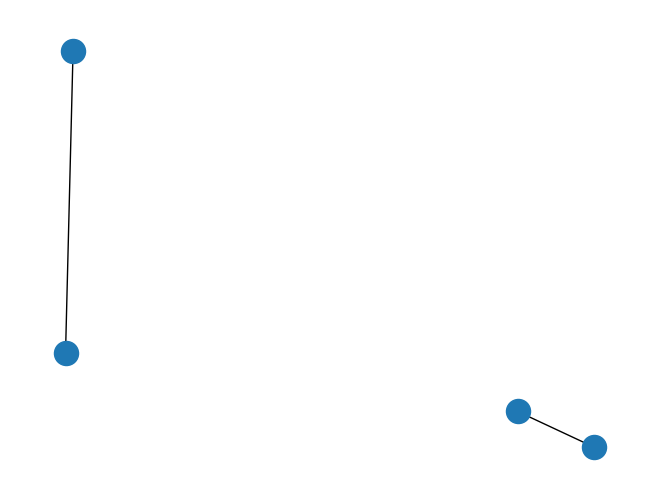

In [39]:
nx.draw(G_sdot)

In [13]:
new_graphs[0].nodes()

NodeView((0, 1, 2, 3, 4))

In [15]:
new_graphs[1].nodes()

NodeView((0, 1, 2, 3, 4))

In [16]:
new_graphs[2].nodes()

NodeView((0, 1, 2, 3, 4))

In [23]:
import matplotlib.pyplot as plt

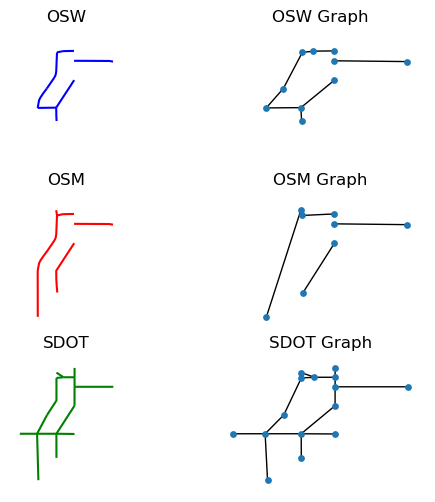

In [24]:
f, ax = plt.subplots(3, 2, figsize=(6, 6), sharex=True, sharey=True)
for row in ax:
    for col in row:
        col.axis("off")

osw_lines.plot(color='blue', ax=ax[0,0])
nx.draw(G_osw, {n:[n[0], n[1]] for n in list(G_osw.nodes)}, ax=ax[0,1], node_size=15)
ax[0,0].set_title('OSW')
ax[0,1].set_title('OSW Graph')

osm_lines.plot(color='red', ax=ax[1,0])
nx.draw(G_osm, {n:[n[0], n[1]] for n in list(G_osm.nodes)}, ax=ax[1,1], node_size=15)
ax[1,0].set_title('OSM')
ax[1,1].set_title('OSM Graph')

sdot_lines.plot(color='green', ax=ax[2,0])
nx.draw(G_sdot, {n:[n[0], n[1]] for n in list(G_sdot.nodes)}, ax=ax[2,1], node_size=15)
ax[2,0].set_title('SDOT')
ax[2,1].set_title('SDOT Graph')
pass

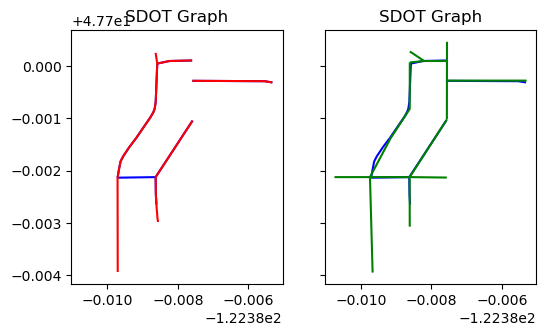

In [25]:
f, ax = plt.subplots(1,2, figsize=(6, 6), sharex=True, sharey=True)

osw_lines.plot(color='blue', ax=ax[0])
osm_lines.plot(color='red', ax=ax[0])
ax[0].set_title('SDOT')
ax[0].set_title('SDOT Graph')

osw_lines.plot(color='blue', ax=ax[1])
sdot_lines.plot(color='green', ax=ax[1])
ax[1].set_title('SDOT')
ax[1].set_title('SDOT Graph')
pass

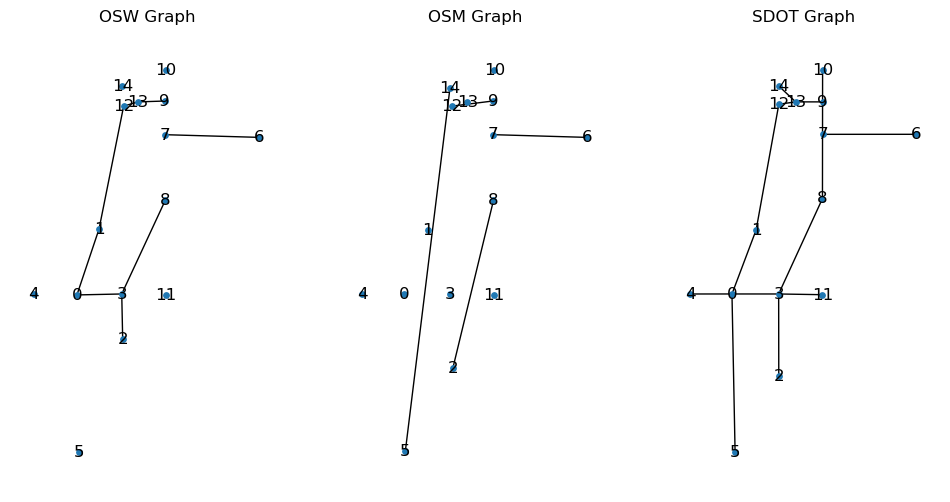

In [33]:
f, ax = plt.subplots(1,3, figsize=(12, 6), sharex=True, sharey=True)
nx.draw(new_graphs[0], pos=attributes[names[0]], ax=ax[0], node_size=15, with_labels=True)
ax[0].set_title('OSW')
ax[0].set_title('OSW Graph')

nx.draw(new_graphs[1], pos=attributes[names[1]], ax=ax[1], node_size=15, with_labels=True)
ax[1].set_title('OSM')
ax[1].set_title('OSM Graph')

nx.draw(new_graphs[2], pos=attributes[names[2]], ax=ax[2], node_size=15, with_labels=True)
ax[2].set_title('SDOT')
ax[2].set_title('SDOT Graph')
pass